In [1]:
!pip install folium

## Description about my problem

My elder brother wants to open a store in Toronto,CA . So I will gather information about stores in Toronto to give him advice whether he should open his store in Toronto.

I will collect the data in the Toronto to check how many stores/shops in Toronto by using Foursquare

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Get credentials

In [3]:
CLIENT_ID = 'IMFRUJ13ERV10OZXAFQBLCMQDTX5L0QV301NCAC5IFMJP2VY' # your Foursquare ID
CLIENT_SECRET = 'SZZMAPVPCOGZE2KVKJSLIN3GQXNCMOHYFUIFHIRFOVK1PFYT' # your Foursquare Secret
VERSION = '20200106' # Foursquare API version
LIMIT = 10

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IMFRUJ13ERV10OZXAFQBLCMQDTX5L0QV301NCAC5IFMJP2VY
CLIENT_SECRET:SZZMAPVPCOGZE2KVKJSLIN3GQXNCMOHYFUIFHIRFOVK1PFYT


## Get latitude and longitude location

In [4]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.653963, -79.387207.


## Build getNearbyVenues function

In [5]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Use BeautifulSoup to collect table

In [6]:
from bs4 import BeautifulSoup
import requests

In [7]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page_response = requests.get(url)
page_content = BeautifulSoup(page_response.content,'html.parser')

In [8]:
table = page_content.find('table',{'class':'wikitable sortable'})
rows = table.find_all('tr')
raw_df = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

In [9]:
for row in rows:
    row_items = row.find_all('td')
    if len(row_items) > 0:
        postcode = row_items[0].text.strip()
        borough = row_items[1].text.strip()
        if borough.lower() != 'not assigned':
            neighborhood = row_items[2].text.strip()
            raw_df = raw_df.append({'PostalCode':postcode, 
                                    'Borough':borough, 
                                    'Neighborhood':neighborhood}, 
                                   ignore_index = True)
raw_df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [10]:
raw_df.shape

(210, 3)

In [11]:
table = raw_df[raw_df['Borough']!='Not assigned'].reset_index().drop('index', axis=1)
table.shape

(210, 3)

In [12]:
table = pd.DataFrame(table.groupby(['PostalCode','Borough'])['Neighborhood'].apply(','.join)).reset_index()
table.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


## Import latitude, longitude of each Postcode

#### Read file Geospatial_Coordinates.csv

In [13]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_acb4ec1c5b4e4d1d93b9537f81b893de = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='fhkEDOCiCI_MFhVncCys4BOz2gbJnlP9PrBDwVAdUqZg',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_acb4ec1c5b4e4d1d93b9537f81b893de.get_object(Bucket='ibm-donotdelete-pr-nwgssxw8mib9fo',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_data_0 = pd.read_csv(body)
df_data_0.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
# Merge 2 tables
df_data_0.columns = ['PostalCode','Latitude','Longitude']
df = pd.merge(table,df_data_0)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Get toronto locations

In [15]:
toronto_index = []
for i in range(0,len(df['PostalCode'])):
    if 'Toronto' in df['Borough'][i]:
        toronto_index.append(i)
toronto = df.iloc[toronto_index,:]
toronto = toronto.reset_index(drop = 'True')
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [16]:
toronto.shape

(39, 5)

## Now I try to get the venues in each Borough by using getNearbyVenues function

In [17]:
toronto_venues = getNearbyVenues(names=toronto['Neighborhood'], latitudes = toronto['Latitude'], longitudes = toronto['Longitude'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvalles
Runnymede

In [18]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [19]:
toronto_venues['Venue Category'].value_counts()

Coffee Shop                      24
Café                             22
Park                             15
Italian Restaurant               13
Restaurant                       12
Gym                               8
Bakery                            8
Bar                               7
Pub                               6
Sushi Restaurant                  6
Dessert Shop                      6
Steakhouse                        6
Gastropub                         6
Greek Restaurant                  6
Ice Cream Shop                    5
Pizza Place                       5
Beer Bar                          5
Gym / Fitness Center              5
Breakfast Spot                    5
Brewery                           5
Vegetarian / Vegan Restaurant     4
Tea Room                          4
Mexican Restaurant                4
Japanese Restaurant               4
American Restaurant               4
Trail                             3
Neighborhood                      3
Supermarket                 

In [20]:
toronto_venues.shape

(346, 7)

## Get all the locations where it is a store or a shop

In [21]:
# Get the indexes
shopping_index = []
for i in range(0, len(toronto_venues['Venue Category'])):
    if 'Shop' in toronto_venues['Venue Category'][i]:
        shopping_index.append(i)
    elif'Store' in toronto_venues['Venue Category'][i]:
        shopping_index.append(i)
# Now get values by index
shopping = toronto_venues.iloc[shopping_index,:]
shopping = shopping.reset_index(drop=True)
shopping.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
1,"The Danforth West,Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
2,"The Danforth West,Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
3,"The Danforth West,Riverdale",43.679557,-79.352188,La Diperie,43.677530,-79.352295,Ice Cream Shop
4,"The Beaches West,India Bazaar",43.668999,-79.315572,British Style Fish & Chips,43.668723,-79.317139,Fish & Chips Shop


In [22]:
shopping.shape

(65, 7)

##  Check how many the shopping stores

In [23]:
shopping['Venue Category'].value_counts()

Coffee Shop               24
Dessert Shop               6
Ice Cream Shop             5
Pet Store                  3
Liquor Store               3
Sporting Goods Shop        2
Comic Shop                 2
Gift Shop                  2
Grocery Store              2
Furniture / Home Store     2
Arts & Crafts Store        2
Clothing Store             2
Fish & Chips Shop          2
Jewelry Store              2
Bubble Tea Shop            1
Candy Store                1
Food & Drink Shop          1
Health Food Store          1
Cosmetics Shop             1
Cheese Shop                1
Name: Venue Category, dtype: int64

In [24]:
print('There are {} uniques stores categories.'.format(len(shopping['Venue Category'].unique())))

There are 20 uniques stores categories.


## Now I try to get the frequency of each category on Neighborhood

In [25]:
shopping_onehot = pd.get_dummies(shopping[['Venue Category']], prefix="", prefix_sep="")
shopping_onehot.head()

,Arts & Crafts Store,Bubble Tea Shop,Candy Store,Cheese Shop,Clothing Store,Coffee Shop,Comic Shop,Cosmetics Shop,Dessert Shop,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gift Shop,Grocery Store,Health Food Store,Ice Cream Shop,Jewelry Store,Liquor Store,Pet Store,Sporting Goods Shop
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [26]:
# add neighborhood column back to dataframe
shopping_onehot['Neighborhood'] = shopping['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [shopping_onehot.columns[-1]] + list(shopping_onehot.columns[:-1])
shopping_onehot = shopping_onehot[fixed_columns]

shopping_onehot.head()

,Neighborhood,Arts & Crafts Store,Bubble Tea Shop,Candy Store,Cheese Shop,Clothing Store,Coffee Shop,Comic Shop,Cosmetics Shop,Dessert Shop,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gift Shop,Grocery Store,Health Food Store,Ice Cream Shop,Jewelry Store,Liquor Store,Pet Store,Sporting Goods Shop
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,"The Danforth West,Riverdale",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"The Beaches West,India Bazaar",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [27]:
# Group the table on Neighborhood and get the frequency of the stores/shops
shopping_onehot = shopping_onehot.groupby('Neighborhood').mean().reset_index()
shopping_onehot.head()

,Neighborhood,Arts & Crafts Store,Bubble Tea Shop,Candy Store,Cheese Shop,Clothing Store,Coffee Shop,Comic Shop,Cosmetics Shop,Dessert Shop,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gift Shop,Grocery Store,Health Food Store,Ice Cream Shop,Jewelry Store,Liquor Store,Pet Store,Sporting Goods Shop
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0
1,"Brockton,Exhibition Place,Parkdale Village",0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0
2,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"Cabbagetown,St. James Town",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0


In [28]:
shopping_grouped = shopping_onehot.groupby('Neighborhood').mean().reset_index()
shopping_onehot.head()

,Neighborhood,Arts & Crafts Store,Bubble Tea Shop,Candy Store,Cheese Shop,Clothing Store,Coffee Shop,Comic Shop,Cosmetics Shop,Dessert Shop,Fish & Chips Shop,Food & Drink Shop,Furniture / Home Store,Gift Shop,Grocery Store,Health Food Store,Ice Cream Shop,Jewelry Store,Liquor Store,Pet Store,Sporting Goods Shop
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0
1,"Brockton,Exhibition Place,Parkdale Village",0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0
2,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,"Cabbagetown,St. James Town",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0


## Print each neighborhood along with the top 5 most stores/shops

In [29]:
num_top_venues = 5

for hood in shopping_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = shopping_grouped[shopping_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                 venue  freq
0         Liquor Store   1.0
1  Arts & Crafts Store   0.0
2      Bubble Tea Shop   0.0
3            Pet Store   0.0
4        Jewelry Store   0.0


----Brockton,Exhibition Place,Parkdale Village----
                    venue  freq
0             Coffee Shop  0.50
1  Furniture / Home Store  0.25
2               Pet Store  0.25
3     Arts & Crafts Store  0.00
4            Liquor Store  0.00


----Business Reply Mail Processing Centre 969 Eastern----
                    venue  freq
0              Comic Shop   1.0
1     Arts & Crafts Store   0.0
2  Furniture / Home Store   0.0
3               Pet Store   0.0
4            Liquor Store   0.0


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
                    venue  freq
0             Coffee Shop   1.0
1     Arts & Crafts Store   0.0
2  Furniture / Home Store   0.0
3               Pet Store   0.0
4            Liquor Store   0.0


----

## Build function to put frequency table above to DataFrame

In [30]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### I will get 3 common stores/shops in each neighborhood

In [31]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = shopping_grouped['Neighborhood']

for ind in np.arange(shopping_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(shopping_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Berczy Park,Liquor Store,Sporting Goods Shop,Dessert Shop
1,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Furniture / Home Store,Pet Store
2,Business Reply Mail Processing Centre 969 Eastern,Comic Shop,Sporting Goods Shop,Pet Store
3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Coffee Shop,Sporting Goods Shop,Pet Store
4,"Cabbagetown,St. James Town",Jewelry Store,Sporting Goods Shop,Dessert Shop


In [32]:
neighborhoods_venues_sorted.shape

(32, 4)

## Cluster neighborhood

### Find the optimal k

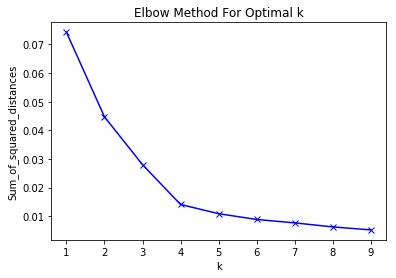

In [33]:
toronto_k = toronto.drop(['PostalCode', 'Borough','Neighborhood'], 1)

# k means determine k
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_k)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From the table above, I would choose the k = 4

In [34]:
kclusters = 4
kmeans = KMeans(n_clusters=kclusters)
kmeans.fit(toronto_k)

# Add cluster labels columns into toronto table
toronto['Cluster Labels'] = kmeans.labels_
toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,2
1,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,2
2,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,2
3,M4M,East Toronto,Studio District,43.659526,-79.340923,2
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0


### Now merge the table tornto with the table Neighborhood venues to get the cluster of each borough

In [35]:
neighborhoods_merged = pd.merge(neighborhoods_venues_sorted,toronto, how = 'left')
neighborhoods_merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,PostalCode,Borough,Latitude,Longitude,Cluster Labels
0,Berczy Park,Liquor Store,Sporting Goods Shop,Dessert Shop,M5E,Downtown Toronto,43.644771,-79.373306,1
1,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Furniture / Home Store,Pet Store,M6K,West Toronto,43.636847,-79.428191,3
2,Business Reply Mail Processing Centre 969 Eastern,Comic Shop,Sporting Goods Shop,Pet Store,M7Y,East Toronto,43.662744,-79.321558,2
3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Coffee Shop,Sporting Goods Shop,Pet Store,M5V,Downtown Toronto,43.628947,-79.394420,1
4,"Cabbagetown,St. James Town",Jewelry Store,Sporting Goods Shop,Dessert Shop,M4X,Downtown Toronto,43.667967,-79.367675,1


## Plot the toronto map

In [36]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [37]:
# Toronto map
toronto_map = folium.Map(location = [latitude,longitude], zoom_start= 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to map
for lat, lon, poi, cluster in zip(neighborhoods_merged['Latitude'], neighborhoods_merged['Longitude'], neighborhoods_merged['Neighborhood'], neighborhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(toronto_map)
       
toronto_map

## Examine clusters and conlcusion on each cluster

### Cluster 1

In [38]:
neighborhoods_merged.loc[neighborhoods_merged['Cluster Labels'] == 0]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,PostalCode,Borough,Latitude,Longitude,Cluster Labels
10,Davisville,Dessert Shop,Coffee Shop,Sporting Goods Shop,M4S,Central Toronto,43.704324,-79.388790,0
11,Davisville North,Clothing Store,Food & Drink Shop,Sporting Goods Shop,M4P,Central Toronto,43.712751,-79.390197,0
12,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",Coffee Shop,Liquor Store,Sporting Goods Shop,M4V,Central Toronto,43.686412,-79.400049,0
15,"Forest Hill North,Forest Hill West",Jewelry Store,Sporting Goods Shop,Dessert Shop,M5P,Central Toronto,43.696948,-79.411307,0
21,North Toronto West,Sporting Goods Shop,Coffee Shop,Dessert Shop,M4R,Central Toronto,43.715383,-79.405678,0


### Cluster 2

In [39]:
neighborhoods_merged.loc[neighborhoods_merged['Cluster Labels'] == 1]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,PostalCode,Borough,Latitude,Longitude,Cluster Labels
0,Berczy Park,Liquor Store,Sporting Goods Shop,Dessert Shop,M5E,Downtown Toronto,43.644771,-79.373306,1
3,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Coffee Shop,Sporting Goods Shop,Pet Store,M5V,Downtown Toronto,43.628947,-79.394420,1
4,"Cabbagetown,St. James Town",Jewelry Store,Sporting Goods Shop,Dessert Shop,M4X,Downtown Toronto,43.667967,-79.367675,1
5,Central Bay Street,Coffee Shop,Sporting Goods Shop,Pet Store,M5G,Downtown Toronto,43.657952,-79.387383,1
6,"Chinatown,Grange Park,Kensington Market",Arts & Crafts Store,Coffee Shop,Pet Store,M5T,Downtown Toronto,43.653206,-79.400049,1
8,Church and Wellesley,Bubble Tea Shop,Sporting Goods Shop,Pet Store,M4Y,Downtown Toronto,43.665860,-79.383160,1
9,"Commerce Court,Victoria Hotel",Coffee Shop,Sporting Goods Shop,Pet Store,M5L,Downtown Toronto,43.648198,-79.379817,1
13,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Sporting Goods Shop,Pet Store,M5K,Downtown Toronto,43.647177,-79.381576,1
14,"First Canadian Place,Underground city",Coffee Shop,Sporting Goods Shop,Pet Store,M5X,Downtown Toronto,43.648429,-79.382280,1
16,"Harbord,University of Toronto",Dessert Shop,Sporting Goods Shop,Pet Store,M5S,Downtown Toronto,43.662696,-79.400049,1


### Cluster 3

In [40]:
neighborhoods_merged.loc[neighborhoods_merged['Cluster Labels'] == 2]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,PostalCode,Borough,Latitude,Longitude,Cluster Labels
2,Business Reply Mail Processing Centre 969 Eastern,Comic Shop,Sporting Goods Shop,Pet Store,M7Y,East Toronto,43.662744,-79.321558,2
27,Studio District,Ice Cream Shop,Cheese Shop,Coffee Shop,M4M,East Toronto,43.659526,-79.340923,2
29,The Beaches,Health Food Store,Sporting Goods Shop,Dessert Shop,M4E,East Toronto,43.676357,-79.293031,2
30,"The Beaches West,India Bazaar",Fish & Chips Shop,Liquor Store,Ice Cream Shop,M4L,East Toronto,43.668999,-79.315572,2
31,"The Danforth West,Riverdale",Ice Cream Shop,Cosmetics Shop,Sporting Goods Shop,M4K,East Toronto,43.679557,-79.352188,2


### Cluster 4

In [41]:
neighborhoods_merged.loc[neighborhoods_merged['Cluster Labels'] == 3]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,PostalCode,Borough,Latitude,Longitude,Cluster Labels
1,"Brockton,Exhibition Place,Parkdale Village",Coffee Shop,Furniture / Home Store,Pet Store,M6K,West Toronto,43.636847,-79.428191,3
7,Christie,Grocery Store,Candy Store,Coffee Shop,M6G,Downtown Toronto,43.669542,-79.422564,3
19,"High Park,The Junction South",Arts & Crafts Store,Furniture / Home Store,Dessert Shop,M6P,West Toronto,43.661608,-79.464763,3
20,"Little Portugal,Trinity",Ice Cream Shop,Sporting Goods Shop,Dessert Shop,M6J,West Toronto,43.647927,-79.419750,3
22,"Parkdale,Roncesvalles",Gift Shop,Dessert Shop,Coffee Shop,M6R,West Toronto,43.648960,-79.456325,3
24,"Runnymede,Swansea",Fish & Chips Shop,Coffee Shop,Pet Store,M6S,West Toronto,43.651571,-79.484450,3


### Conclusion

Due to the demanding of my brother to open a store in Toronto. I would recommend him 
* **On the left area of Toronto (Cluster 3):** 
    I would like to recommend him to avoid opening the furniture store on the left Toronto due to it already has 2 furniture store. On these area, I would recommend him to open a coffee shop instead.

* **On the center area of Toronto (Cluster 0):**
    I would like him not to open the coffee shop in here due to most of coffee shop was located in here. Beside that, opening a furniture store is the great idea in this area.
* **On the above area of Toronto (Cluster 2):**
    I would like him should consider the furniture shop in here due to it has no furniture store in this area.
* **On the right area of Toronto (Cluster 1):**
    I would like him should consider the furniture shop in here due to it has no furniture store in this area.

In general, Toronto is the best place for my brother to open a furniture shop due to it has a very small quantity of funiture shops. Beside that, the price of hiring a place to open a store in this area should be consider but I would not like to mention it on this Notebook.